### Plotting alignment data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import json
import csv
import math
import pandas as pd
import utils.db_utils as db
import utils.plot_utils as plot
import utils.file_utils as file
import config

############################################
# get configuration
cfg = config.getConfig() # configure values in config.js
############################################

targetLang = cfg['targetLang']
bibleType = cfg['targetBibleType']
tWordsTypeList = cfg['tWordsTypeList']
dbPath = cfg['dbPath']
trainingDataPath = cfg['trainingDataPath']
testamentStr = cfg['testamentStr']
baseDataPath = cfg['baseDataPath']

type_ = 'kt'

In [2]:
# get alignments for tW keyterms

minAlignments = 40
remove = ['ὁ', 'τὸ', 'τὰ']
alignmentsForWord, filteredAlignmentsForWord = db.fetchAlignmentDataForTWordCached(trainingDataPath, type_, bibleType, minAlignments, remove)
print(f"Original Language Alignments: {len(filteredAlignmentsForWord)}")

Using cached Alignments
Unfiltered Alignments: 4368
filtered alignments by original list count is 105
Size of filtered alignments by original ./data/en/ult/TrainingData/kt_en_ult_NT_alignments_by_orig_40.json is 6.265 MB
Size of filtered alignments by original ./data/en/ult/TrainingData/kt_en_ult_NT_alignments_by_orig_40.csv is 1.678 MB
Filtered Alignments: 105
Original Language Alignments: 105


### Analysis of alignments for tWord keyterms in the en_ult:

#### Frequency of alignments:
_***Note that each line on the graphs below represents an alignment for a specific word. For example we have separate lines for 'Θεός', 'Θεὸς', or 'Θεοῦ' even though they have the same lemma.  It made sense to group the alignments this way since aligners are likely to choose different target language words based on morphology of the word._

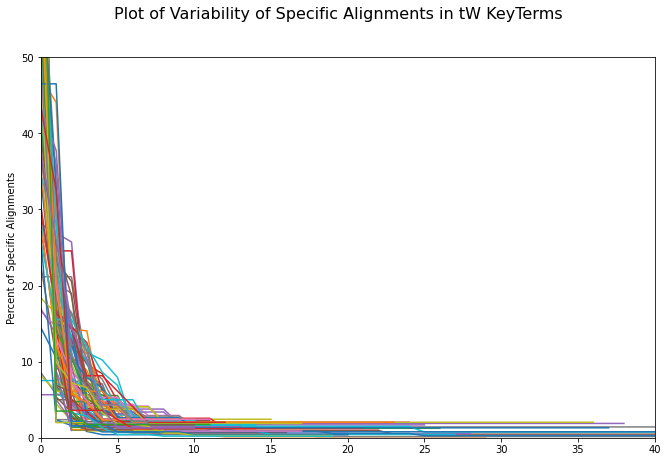

In [3]:
frequenciesOfAlignments, stats = db.getFrequenciesOfFieldInAlignments(filteredAlignmentsForWord, 'alignmentText')

title = f"Plot of Variability of Specific Alignments in tW KeyTerms"
ylabel = "Percent of Specific Alignments"
xlimit = [0, 40]
plotData = plot.plotFrequencies(frequenciesOfAlignments, title, ylabel, showXValues=False, xlimit=xlimit)

In [4]:
stats = []
for word in frequenciesOfAlignments.keys():
    frequency = frequenciesOfAlignments[word]
    alignments = filteredAlignmentsForWord[word]
    total = len(alignments)
    counts = list(frequency.values)
    ratio = list(map(lambda x: x/total, counts))
    countsSeries = frequency.describe()
    alignments = filteredAlignmentsForWord[word]
    stats.append({
        'originalWord': word,
        'alignments': alignments,
        'frequency': frequency,
        'counts': counts,
        'countsSeries': countsSeries,
        'total': total,
        'ratio': ratio
    })

path_ = f'{trainingDataPath}/kt_en_ult_NT_alignments_stats.csv'
stats_ = pd.DataFrame(stats).drop(columns=['alignments'])
db.saveDataFrameToCSV(path_, stats_)
stats_.head()

,originalWord,frequency,counts,countsSeries,total,ratio
0,Φαρισαῖοι,Φαρισαῖοι = Pharisees 47 οἱ Φαρισαῖοι =...,"[47, 1, 1]",count 3.000000 mean 16.333333 std ...,49,"[0.9591836734693877, 0.02040816326530612, 0.02..."
1,αἰώνιον,αἰώνιον = eternal ...,"[35, 3, 2, 2, 1, 1, 1]",count 7.000000 mean 6.428571 std ...,45,"[0.7777777777777778, 0.06666666666666667, 0.04..."
2,αἷμα,αἷμα = blood 28 τὸ αἷμα = blood ...,"[28, 7, 2, 1, 1, 1, 1]",count 7.000000 mean 5.857143 std ...,41,"[0.6829268292682927, 0.17073170731707318, 0.04..."
3,Βασιλεία,Βασιλεία = kingdom 45 Βασιλεία = of ...,"[45, 1]",count 2.000000 mean 23.000000 std ...,46,"[0.9782608695652174, 0.021739130434782608]"
4,γένηται,γένηται = may be 3 γένητ...,"[3, 3, 3, 3, 3, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, ...",count 39.000000 mean 1.358974 std ...,53,"[0.05660377358490566, 0.05660377358490566, 0.0..."


### Analysis:

#### Analysis of numerical metrics:

#### Analysis of original language word count:

Found 105 original language words for tW type kt


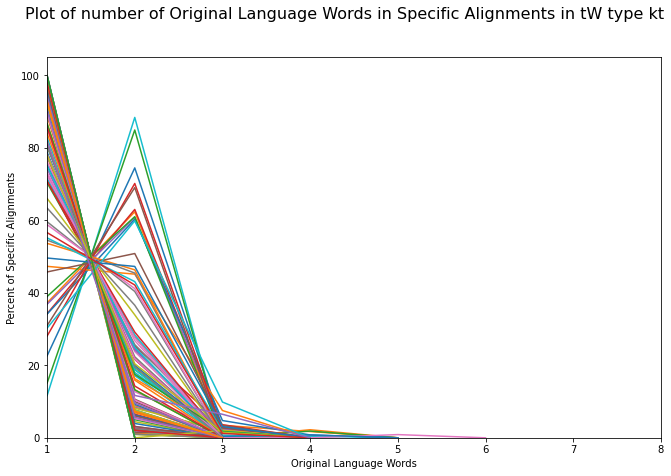

In [5]:
field = 'origWordsCount'
field_frequencies, stats = db.getFrequenciesOfFieldInAlignments(filteredAlignmentsForWord, field, sortIndex = True)
filledFrequencies = db.zeroFillFrequencies(field_frequencies)

print(f"Found {len(field_frequencies)} original language words for tW type {type_}")
title = f"Plot of number of Original Language Words in Specific Alignments in tW type {type_}"
ylabel = "Percent of Specific Alignments"
xlabel = "Original Language Words"
plot.plotXYdataDict(filledFrequencies, title, ylabel, xlabel, showXValues=True, xlimit=[1, 8])


##### Notes:
- this field analysis suggests that original word counts are tight - a threshold word count of 3 probably good for English to flag for review.
<p></p>

Out of 105, found 3 original language words that have instances with over 4 words


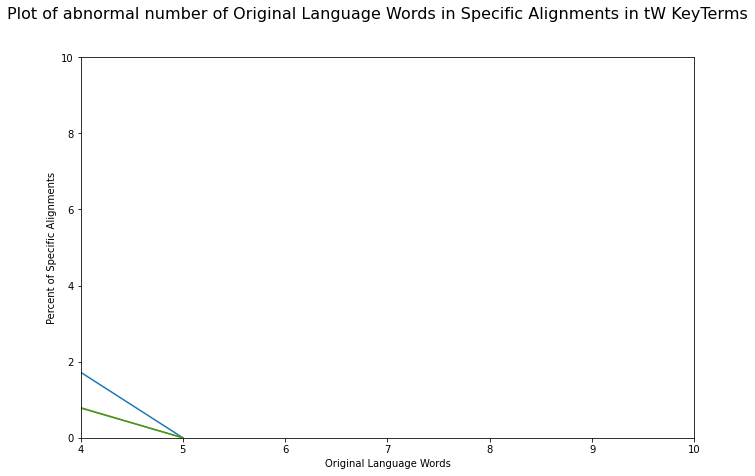

In [6]:
threshold = 4
abnormalAlignments = {}
for origWord in field_frequencies:
    frequency = field_frequencies[origWord]
    count = len(frequency)
    if count >= threshold:
        abnormalAlignments[origWord] = frequency

print(f"Out of {len(field_frequencies)}, found {len(abnormalAlignments)} original language words that have instances with over {threshold} words")
filledFrequencies = db.zeroFillFrequencies(abnormalAlignments)

title = f"Plot of abnormal number of Original Language Words in Specific Alignments in tW KeyTerms"
ylabel = "Percent of Specific Alignments"
xlabel = "Original Language Words"
plot.plotXYdataDict(filledFrequencies, title, ylabel, xlabel, showXValues=True, xlimit=[threshold, 10], ylimit=[0, 10])

#### Analysis of target language word count:

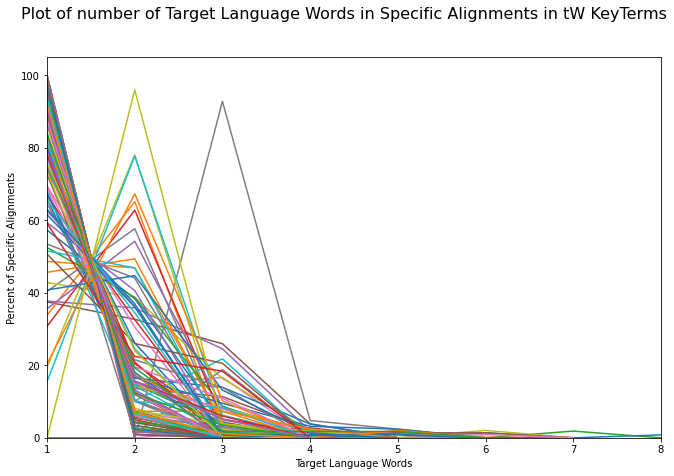

In [7]:
field = 'targetWordsCount'
field_frequencies, stats = db.getFrequenciesOfFieldInAlignments(filteredAlignmentsForWord, field, sortIndex = True)
filledFrequencies = db.zeroFillFrequencies(field_frequencies)

title = f"Plot of number of Target Language Words in Specific Alignments in tW KeyTerms"
ylabel = "Percent of Specific Alignments"
xlabel = "Target Language Words"
plot.plotXYdataDict(filledFrequencies, title, ylabel, xlabel, showXValues=True, xlimit=[1, 8])

##### Notes:
- this field analysis suggests that a threshold word count of 3 probably good for English to flag for review.
<p></p>

#### Analysis of count of extra unaligned words between aligned original language words:

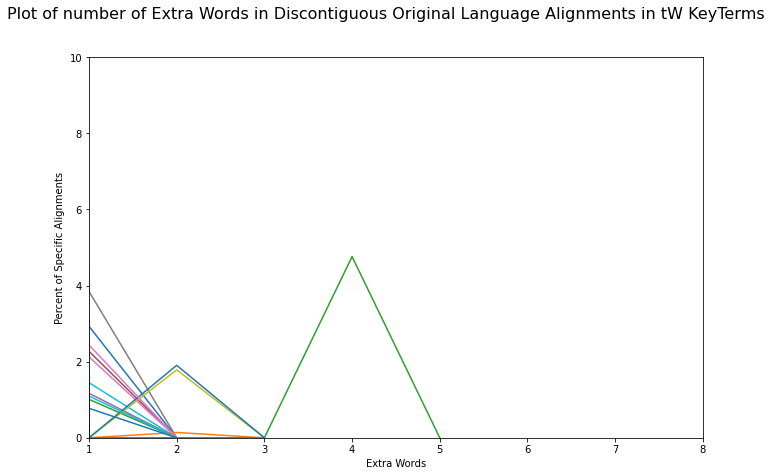

In [8]:
field = 'origWordsBetween'
field_frequencies, stats = db.getFrequenciesOfFieldInAlignments(filteredAlignmentsForWord, field, sortIndex = True)
filledFrequencies = db.zeroFillFrequencies(field_frequencies)

title = f"Plot of number of Extra Words in Discontiguous Original Language Alignments in tW KeyTerms"
ylabel = "Percent of Specific Alignments"
xlabel = "Extra Words"
plot.plotXYdataDict(filledFrequencies, title, ylabel, xlabel, showXValues=True, xlimit=[1, 8], ylimit=[0,10])

##### Notes:
- this field analysis suggests that most original language alignments probably good. Probably the cases of a word between aligned words should be reviewed.
<p></p>

#### Analysis of count of extra unaligned words between aligned target language words:

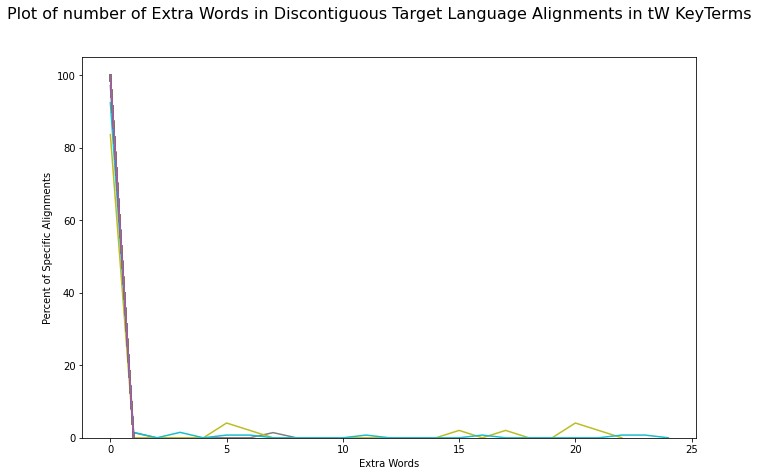

In [9]:
field = 'targetWordsBetween'
field_frequencies, stats = db.getFrequenciesOfFieldInAlignments(filteredAlignmentsForWord, field, sortIndex = True)
filledFrequencies = db.zeroFillFrequencies(field_frequencies)

title = f"Plot of number of Extra Words in Discontiguous Target Language Alignments in tW KeyTerms"
ylabel = "Percent of Specific Alignments"
xlabel = "Extra Words"
plot.plotXYdataDict(filledFrequencies, title, ylabel, xlabel, showXValues=True)

##### Notes:
- this field analysis suggests that most target language alignments are very tight.

#### Generate CSV of questionable alignments:

In [10]:
print(f"Testing tWords {type_} with minimum of {minAlignments} alignments")

thresholds = {
    'alignmentOrigWordsThreshold': 3,
    'alignmentTargetWordsThreshold': 5,
    'origWordsBetweenThreshold': 1,
    'targetWordsBetweenThreshold': 1,
    'alignmentFrequencyMinThreshold': 5
}

warningData,summary = db.generateWarningsAndSummary(baseDataPath, type_, bibleType, testamentStr, filteredAlignmentsForWord,
                                                     thresholds, tag=f'{minAlignments}')
print(f"Found {len(warningData)} alignments to check - min threshold {minAlignments}")

Testing tWords kt with minimum of 40 alignments
saved summary of 105 original words to ./data/en/ult/kt_en_ult_NT_summary_40.csv
Found 1119 alignments to check - min threshold 40


In [11]:
print(f"Testing all tWords {type_}")

minAlignments = 0
alignmentsForWord, filteredAlignmentsForWord0 = db.fetchAlignmentDataForTWordCached(trainingDataPath, type_, bibleType, minAlignments, remove)
print(f"Original Language Alignments: {len(filteredAlignmentsForWord)}")

warningData2,summary2 = db.generateWarningsAndSummary(baseDataPath, type_, bibleType, testamentStr, filteredAlignmentsForWord0,
                                                     thresholds, tag=f'{minAlignments}')

print(f"Found {len(warningData2)} alignments to check - min threshold {minAlignments}")

Testing all tWords kt
Using cached Alignments
Unfiltered Alignments: 4368
filtered alignments by original list count is 4344
Size of filtered alignments by original ./data/en/ult/TrainingData/kt_en_ult_NT_alignments_by_orig_0.json is 16.552 MB
Size of filtered alignments by original ./data/en/ult/TrainingData/kt_en_ult_NT_alignments_by_orig_0.csv is 4.478 MB
Filtered Alignments: 4344
Original Language Alignments: 105
saved summary of 4344 original words to ./data/en/ult/kt_en_ult_NT_summary_0.csv
Found 1608 alignments to check - min threshold 0


In [12]:
print(f"saved summary of {len(summary2)} original words")
summary2

saved summary of 4344 original words


{'Αἵματος': {'orginalWord': 'Αἵματος',
  'lemma': 'αἷμα',
  'strong': 'G01290',
  'alignmentsForOriginalWord': 2,
  'alignmentFrequency%': {'Αἵματος = of Blood': 100.0},
  'alignmentFreq': [2],
  'alignmentFrequencyBins': {2: 1},
  'alignmentFreq-min': 2,
  'alignmentFreq-max': 2,
  'alignmentFreq-mean': 2.0,
  'alignmentFreq-stddev': 0.0,
  'alignmentFreq-total': 2,
  'alignmentFreq-meanNormalized': 1.0,
  'alignmentFreq-stddevNormalized': 0.0,
  'origWordsCount-min': 1,
  'origWordsCount-max': 1,
  'origWordsCount-mean': 1.0,
  'origWordsCount-stddev': 0.0,
  'origWordsCount-total': 2,
  'origWordsCount-meanNormalized': 0.5,
  'origWordsCount-stddevNormalized': 0.0,
  'origWordsBetween-min': 0,
  'origWordsBetween-max': 0,
  'origWordsBetween-mean': 0.0,
  'origWordsBetween-stddev': 0.0,
  'origWordsBetween-total': 0,
  'origWordsBetween-meanNormalized': 0,
  'origWordsBetween-stddevNormalized': 0,
  'targetWordsCount-min': 2,
  'targetWordsCount-max': 2,
  'targetWordsCount-mean': 2